# January 18-20, 2023: The Virtual Brain (TVB): create network dynamics

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import tvb.simulator.lab as tsl
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
from tvb.simulator.plot.timeseries_interactive import TimeSeriesInteractivePlotter

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/jan23"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

/home/govindas/venvs/nw_estim/lib/python3.9/site-packages/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
def plot_roi_time_series(args, time, data):
    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 5)), 5
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=True, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    state_var = 0

    for idx_roi, roi in enumerate(np.arange(data.shape[2])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        

        ax.set_title(f"ROI {roi:02}")

        ax.plot(
            data[:, state_var, idx_roi, 0],
            color='cornflowerblue',
            linewidth=3,
        )

        # ax.fill_between()

        ax.set_xlabel(f"time (s)")
        ax.set_ylabel(f"activity")

        spc = len(time) // 5
        pos = np.arange(0, len(time), spc)
        labels = np.round(time[::spc]) / 1000
        #f"{np.array2string(time[::spc], precision=2, floatmode='fixed')}".split(" ")
        ax.set_xticks(pos, labels)
        ax.grid(True)

    # fig.show()

    return None

In [3]:
class ARGS(): pass
args = ARGS()

## connectome

In [4]:
wm = tsl.connectivity.Connectivity()

args.num_rois = 12
wm.number_of_regions = args.num_rois

# weights – connection strengths, i.e. number of fibres
weights = np.random.randn(args.num_rois, args.num_rois)
weights = (weights + weights.T) / 2
weights[np.diag_indices(args.num_rois)] = 0.0
weights[weights < 0] = 0.0
wm.set_weights(weights, args.num_rois)

# fibre lengths 
tract_lengths = weights * 42
wm.set_tract_lengths(tract_lengths, args.num_rois)

# roi centers
wm.centres_spherical(args.num_rois)

# roi names
wm.create_region_labels()

# hemispheres
hemispheres = np.array(
    [False for _ in range(len(wm.region_labels) // 2)] + 
    [True for _ in range(len(wm.region_labels) // 2)]
)
wm.set_hemispheres(hemispheres, args.num_rois)

# configure
wm.configure()

In [5]:
# wm = tsl.connectivity.Connectivity()
# wm.motif_chain_directed(num_rois)
# wm.centres_spherical(num_rois)
# wm.create_region_labels()
# wm.configure()

## dynamics model

### generic 2D oscillator

WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0000 s
   INFO  step 64001 time 1.0000 s
   INFO  step 128001 time 2.0000 s
   INFO  step 192001 time 3.0000 s
   INFO  step 256001 time 4.0000 s
   INFO  step 320001 time 5.0000 s
   INFO  step 384001 time 6.0000 s
   INFO  step 448001 time 7.0000 s
   INFO  step 512001 time 8.0000 s
   INFO  step 576001 time 9.0000 s


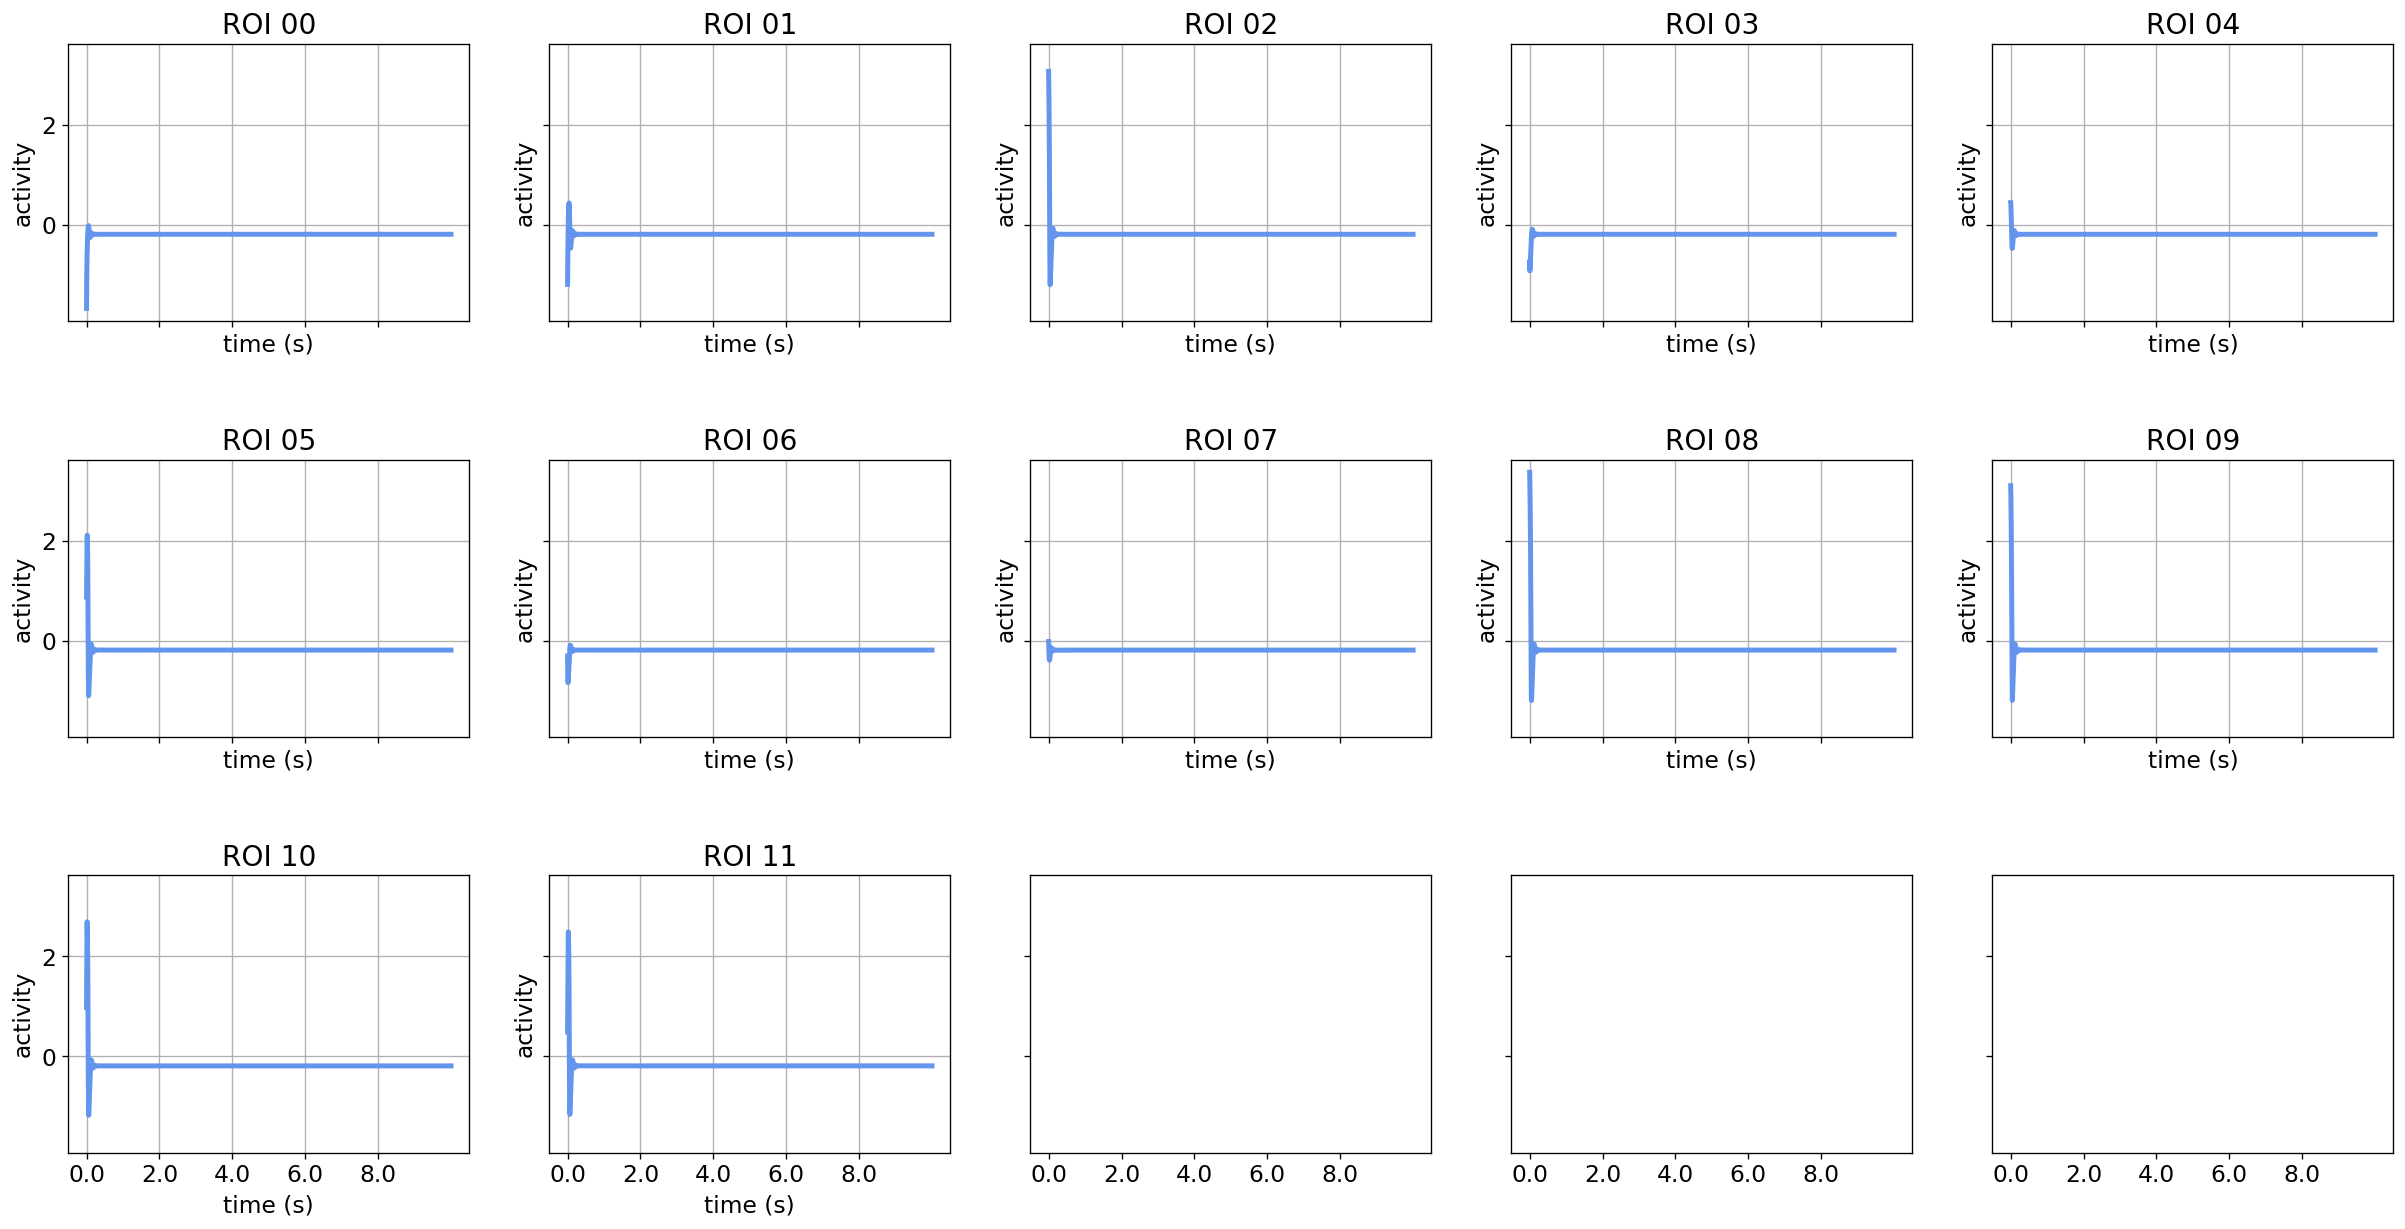

In [6]:
oscillator = tsl.models.oscillator.Generic2dOscillator(
    variables_of_interest=['V'], #, 'W', 'V - W'], 
    # a=np.array([1.05]), 
    # b=np.array([-1.00]),
    # c=np.array([0.0]),
    # d=np.array([0.1]),
    # I=np.array([0.0]),
    # alpha=np.array([1.0]),
    # beta=np.array([0.2]),
    # gamma=np.array([-1.0]),
    # e=np.array([0.0]),
    # g=np.array([1.0]),
    # f=np.array([1/3]),
    # tau=np.array([1.25]),
)

coupling = tsl.coupling.Linear(a=np.array([0.0126]))

integrator = tsl.integrators.HeunDeterministic(dt=2**-6)

args.period = 2**-3 # ms
monitors = (
    # tsl.monitors.RawVoi(),
    # tsl.monitors.Bold(),
    tsl.monitors.TemporalAverage(period=args.period),
    tsl.monitors.ProgressLogger(period=1e3),
)

# %matplotlib widget
# ppi = PhasePlaneInteractive(model=oscillator)
# ppi.show()

sim = tsl.simulator.Simulator(
    model=oscillator, 
    connectivity=wm, 
    coupling=coupling, 
    integrator=integrator,
    monitors=monitors,
    simulation_length=1e4,
).configure()

# (time, data) = sim.run()
run_res = sim.run()
time, data = run_res[0]
# `data` dimensions are ("Time", "State Variable", "Region", "Mode")
time.shape, data.shape

args.subplot_layout = 'row-col'
plot_roi_time_series(args, time, data)

In [7]:
# just to ensure that the order of variables in the `data` 
# is same as that we set in the `model` (here 'V', 'W', 'V - W').
# assert(
#     np.all(
#         np.isclose(
#             data[:5, 0, :, :].squeeze() - data[:5, 1, :, :].squeeze(),
#             data[:5, 2, :, :].squeeze()
#         )
#     )
# )

# tsr = tsl.time_series.TimeSeriesRegion()
# tsr.time = time
# tsr.data = data
# tsr.sample_period = args.period / 1000
# tsr.sample_period_unit = 's'
# tsr.connectivity = wm
# tsr.time

# # %matplotlib widget
# tsi = TimeSeriesInteractivePlotter(time_series=tsr)
# tsi.configure()
# tsi.show()

### reduced Wong-Wang model

   INFO  step 1 time 0.0001 s
   INFO  step 8001 time 1.0001 s
   INFO  step 16001 time 2.0001 s
   INFO  step 24001 time 3.0001 s
   INFO  step 32001 time 4.0001 s
   INFO  step 40001 time 5.0001 s
   INFO  step 48001 time 6.0001 s
   INFO  step 56001 time 7.0001 s
   INFO  step 64001 time 8.0001 s
   INFO  step 72001 time 9.0001 s


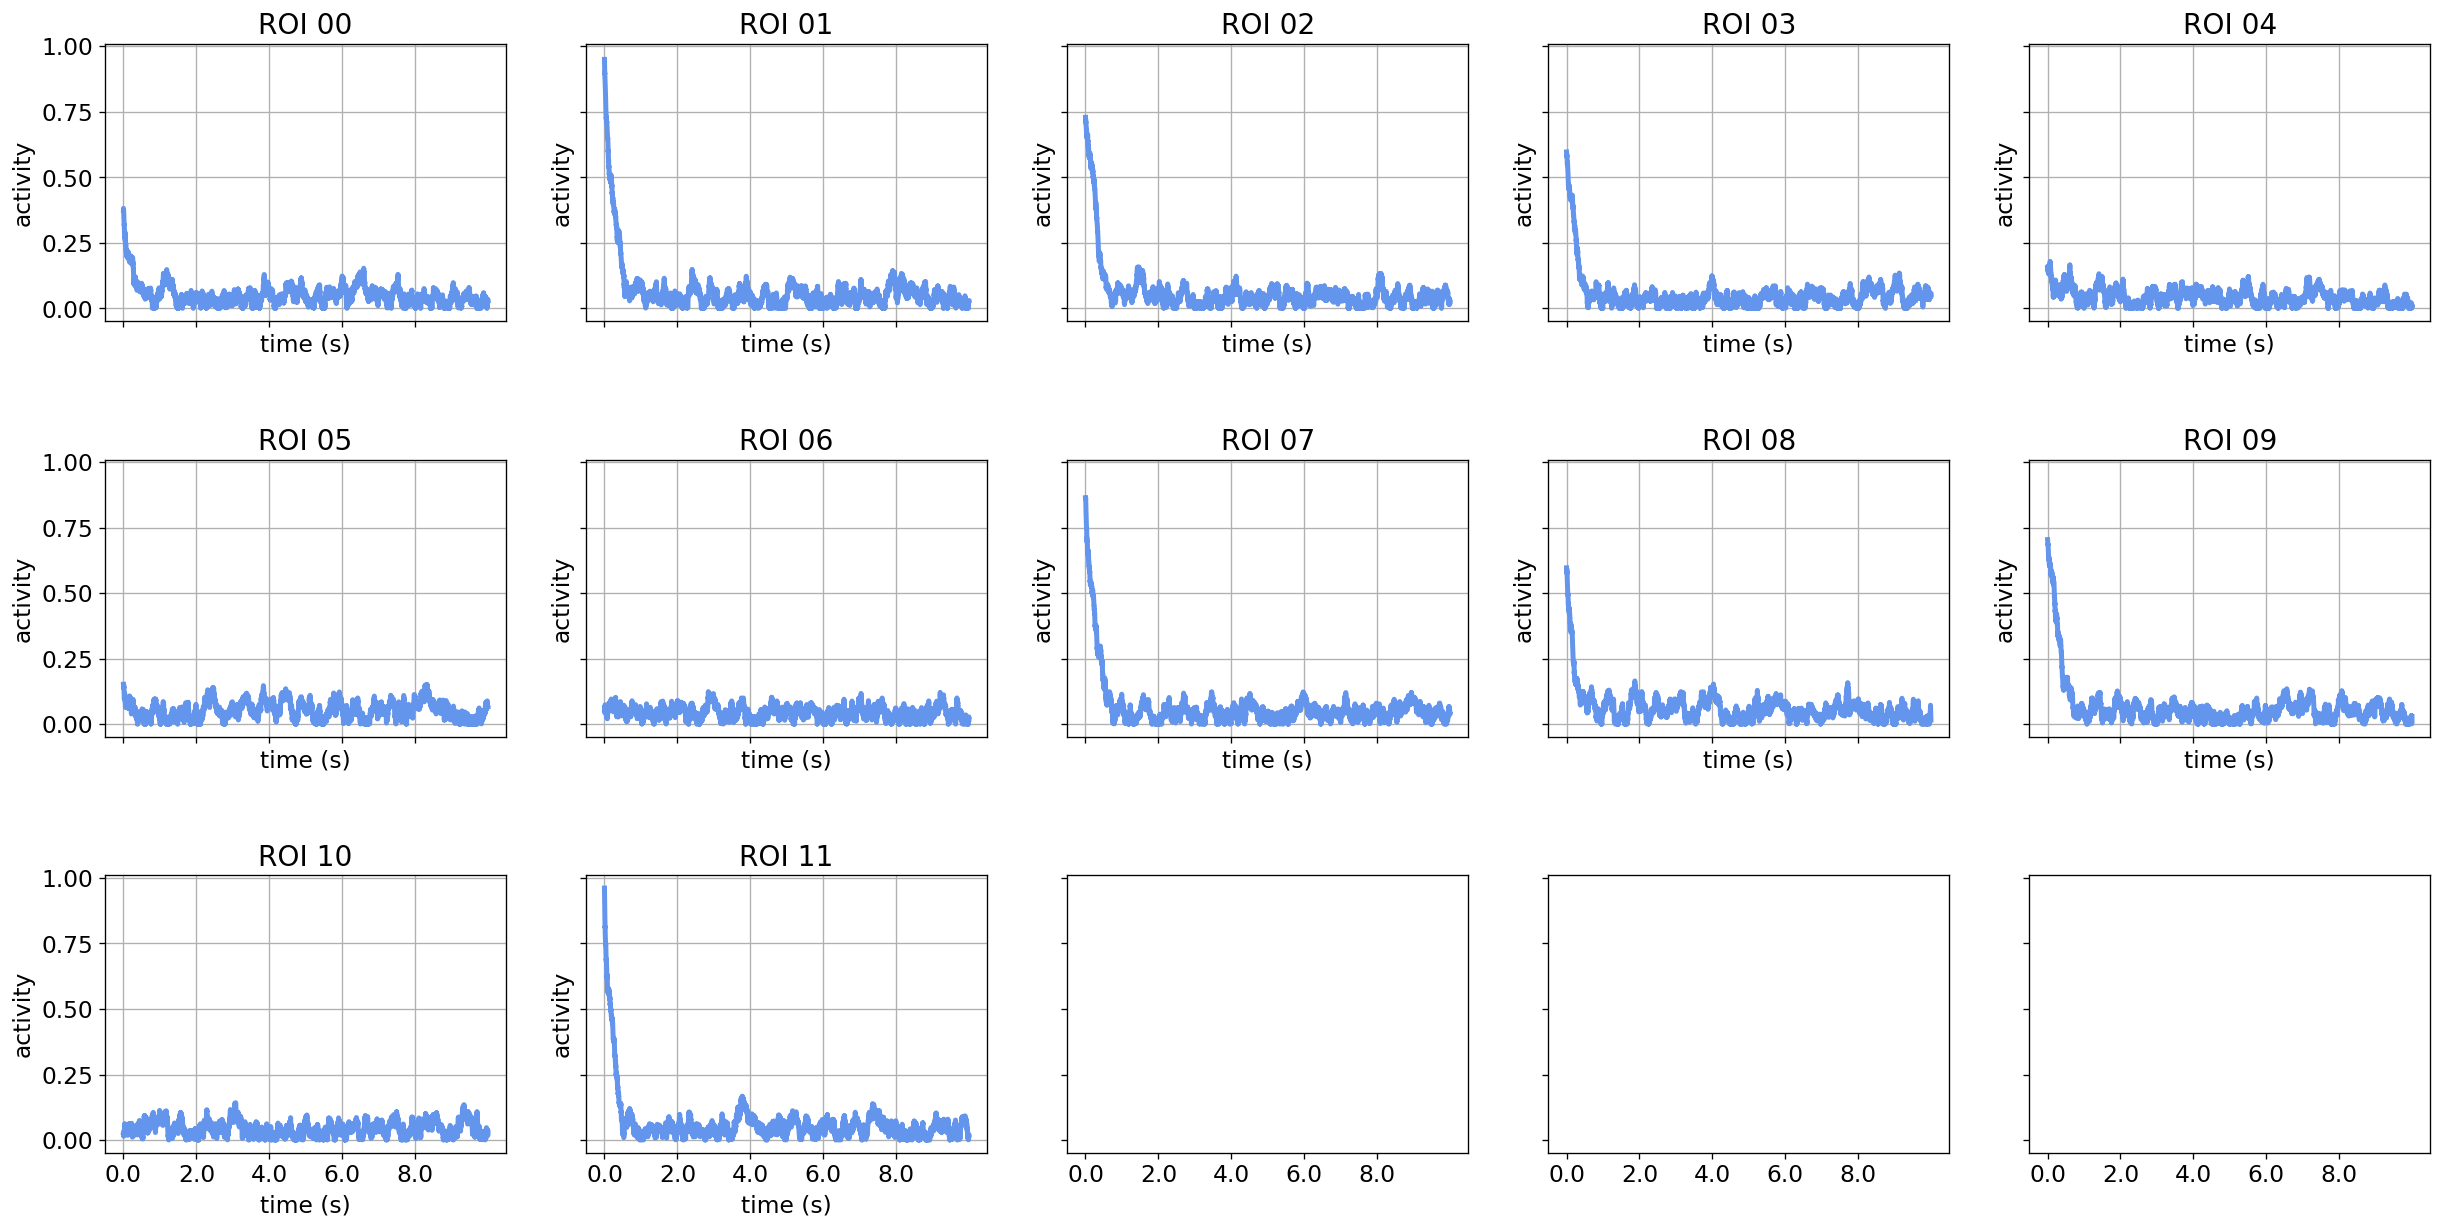

In [8]:
model = tsl.models.ReducedWongWang(
    a=np.array([0.27]),
    w=np.array([1.0]),
    I_o=np.array([0.3]),
)

coupling = tsl.coupling.Linear(a=np.array([0.5 / 50]))

integrator = tsl.integrators.EulerStochastic(dt=2**-3, noise=tsl.noise.Additive(nsig=np.array([1e-5])))
# tsl.integrators.HeunDeterministic(dt=2**-3)

args.period = 1.0
monitors = (
    # tsl.monitors.RawVoi(),
    # tsl.monitors.Bold(),
    tsl.monitors.TemporalAverage(period=args.period),
    tsl.monitors.ProgressLogger(period=1e3),
)

sim = tsl.simulator.Simulator(
    model=model, 
    connectivity=wm, 
    coupling=coupling, 
    integrator=integrator,
    monitors=monitors,
    simulation_length=1e4,
).configure()

run_res = sim.run()
time, data = run_res[0]
time.shape, data.shape

args.subplot_layout = 'row-col'
plot_roi_time_series(args, time, data)

noisy fluctuations due to noisy integration...
may not carry much meaning...

### Jansen and Rit model

   INFO  step 1 time 0.0001 s


/home/govindas/venvs/nw_estim/lib/python3.9/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/govindas/venvs/nw_estim/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


   INFO  step 16001 time 1.0001 s
   INFO  step 32001 time 2.0001 s
   INFO  step 48001 time 3.0001 s
   INFO  step 64001 time 4.0001 s
   INFO  step 80001 time 5.0001 s
   INFO  step 96001 time 6.0001 s
   INFO  step 112001 time 7.0001 s
   INFO  step 128001 time 8.0001 s
   INFO  step 144001 time 9.0001 s


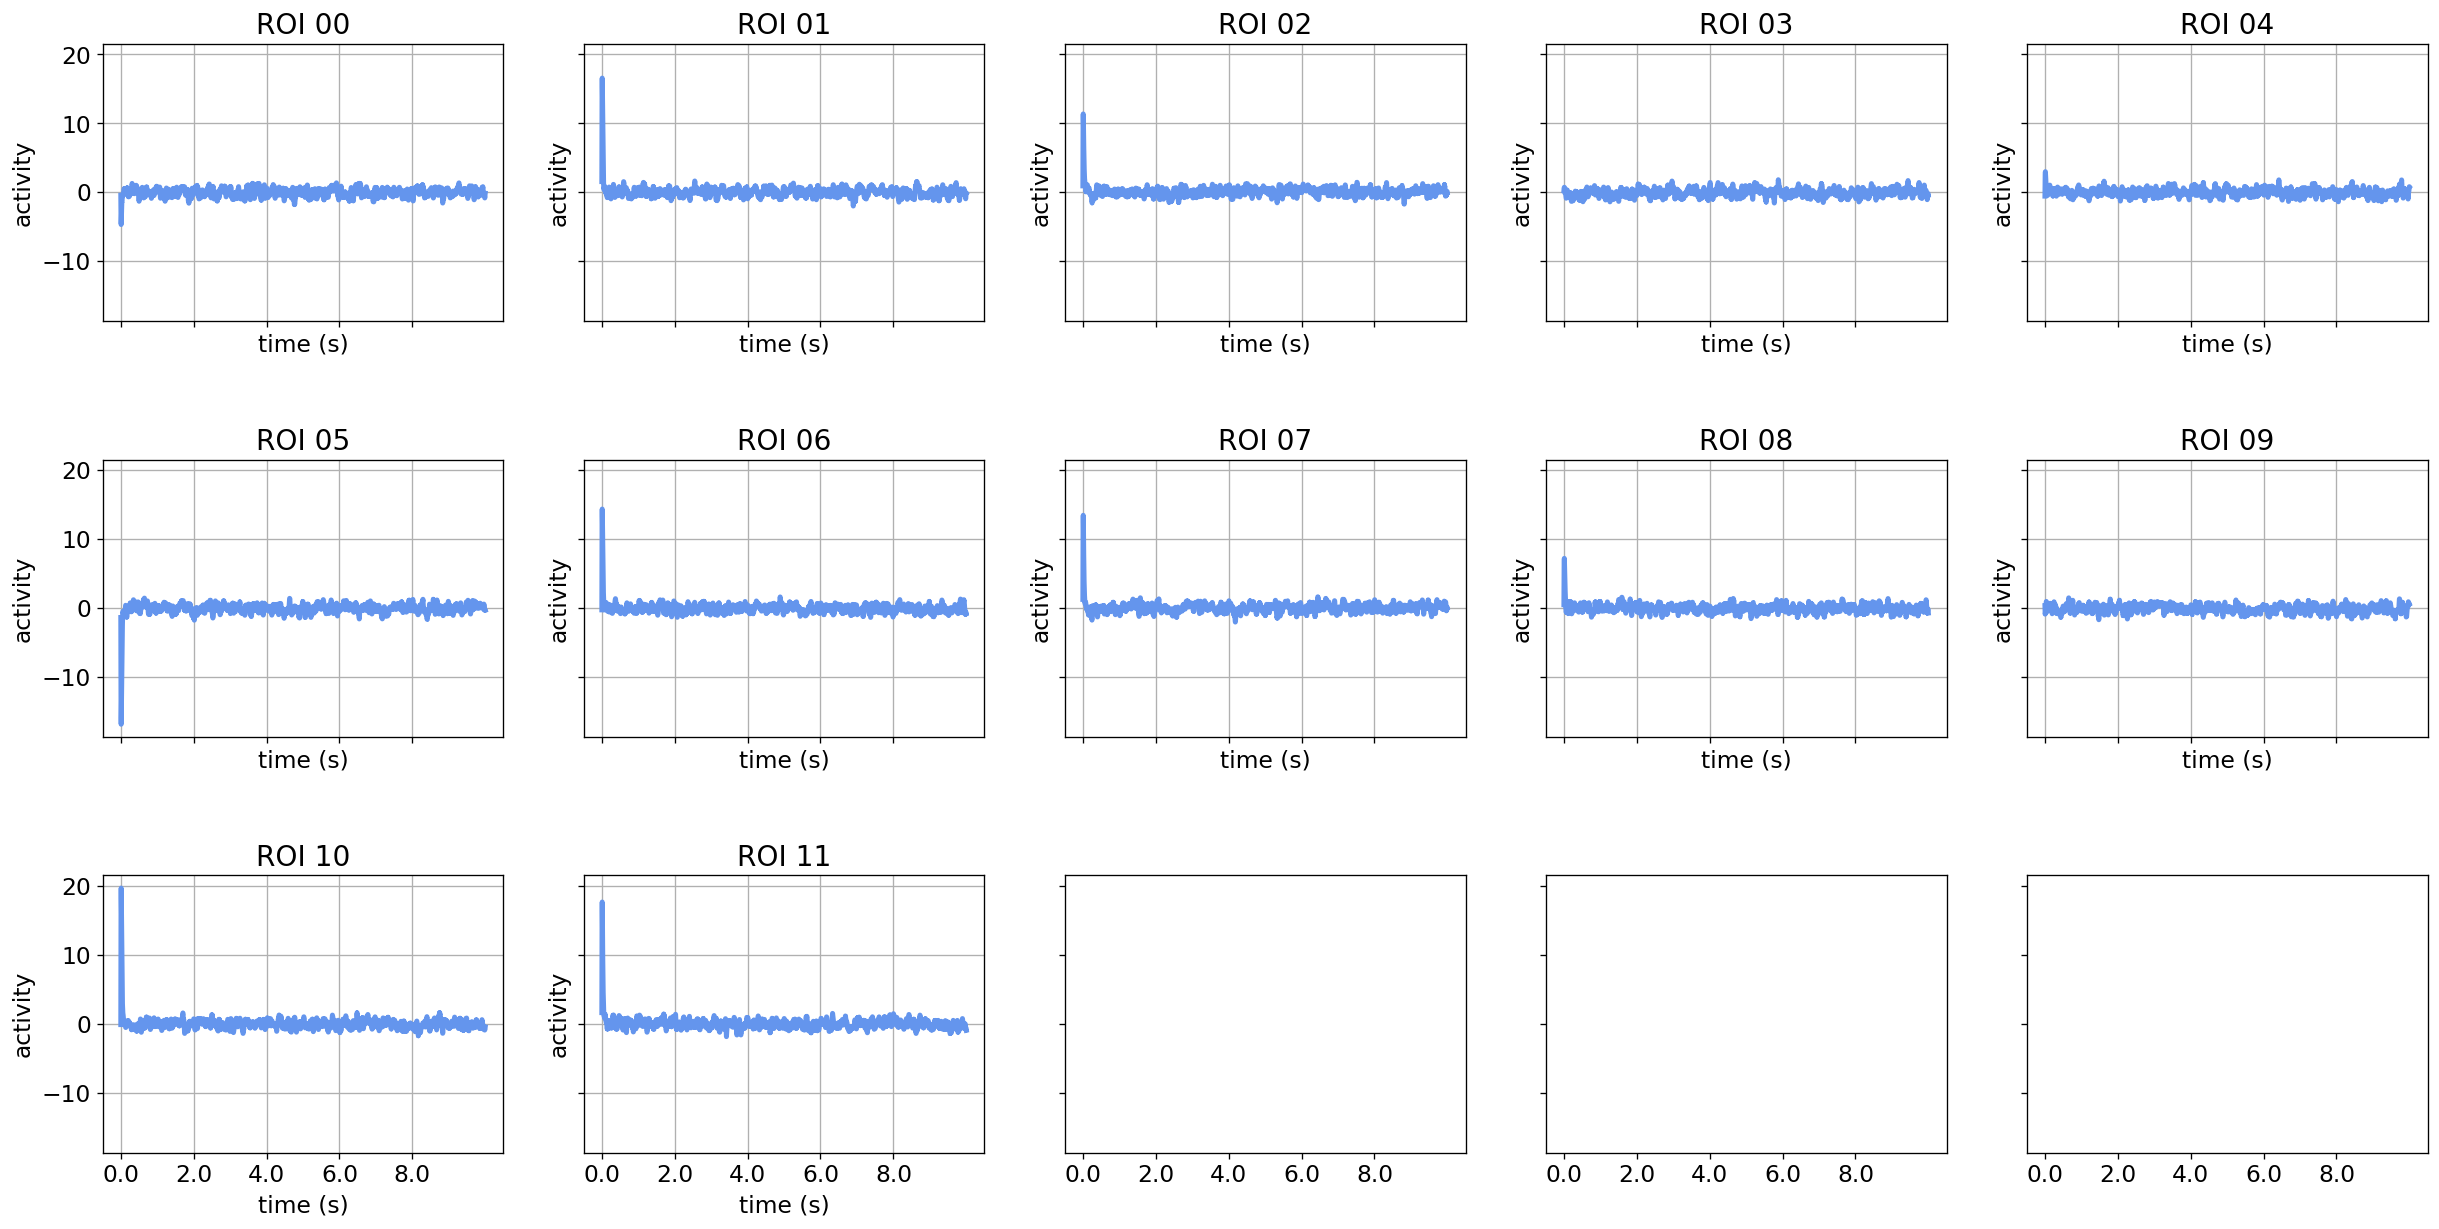

In [9]:
model = tsl.models.JansenRit(
    mu=np.array([0.0]),
    v0=np.array(6.0),
)
phi_n_scaling = (model.a * model.A * (model.p_max-model.p_min) * 0.5 )**2 / 2.
sigma         = np.zeros(6) 
sigma[3]      = phi_n_scaling

coupling = tsl.coupling.SigmoidalJansenRit(a=np.array([10.0]))

integrator = tsl.integrators.HeunStochastic(dt=2**-4, noise=tsl.noise.Additive(nsig=sigma))
# tsl.integrators.HeunDeterministic(dt=2**-3)

args.period = 2**-2
monitors = (
    # tsl.monitors.RawVoi(),
    # tsl.monitors.Bold(),
    tsl.monitors.TemporalAverage(period=args.period),
    tsl.monitors.ProgressLogger(period=1e3),
)

sim = tsl.simulator.Simulator(
    model=model, 
    connectivity=wm, 
    coupling=coupling, 
    integrator=integrator,
    monitors=monitors,
    simulation_length=1e4,
).configure()

run_res = sim.run()
time, data = run_res[0]
time.shape, data.shape

plot_roi_time_series(args, time, data)

### Wilson Cowan model

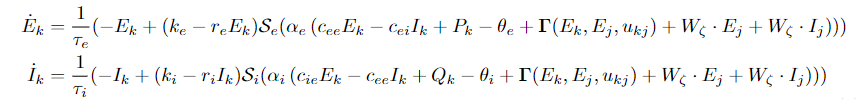

In [10]:
from IPython.display import Image
Image(filename='wilson_cowan_equations.PNG') 

/tmp/ipykernel_7975/506660618.py:5: DeprecationWarning: Call to deprecated class PhasePlaneInteractive. (Use tvb-widgets instead)
  ppi = PhasePlaneInteractive(


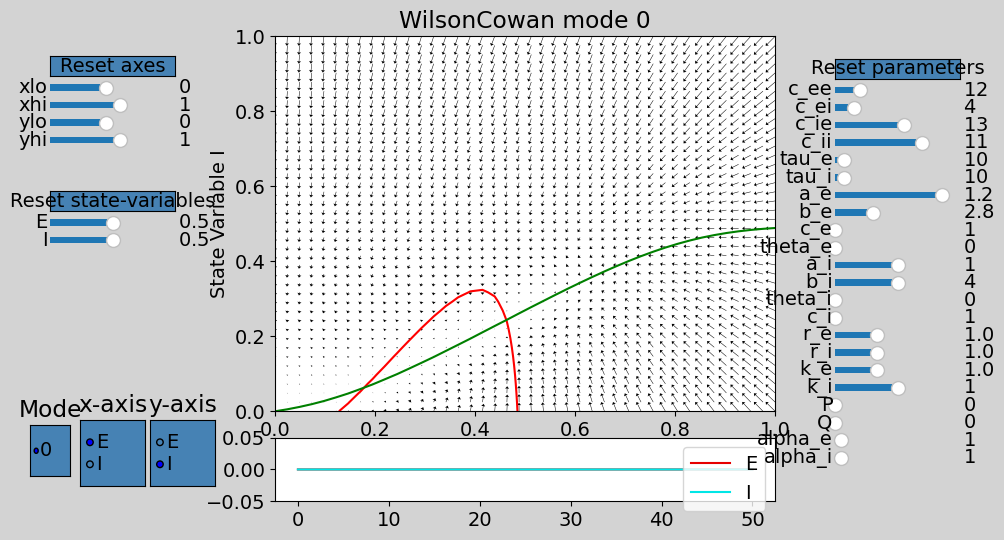

In [11]:
# %matplotlib widget

wc = tsl.models.WilsonCowan()

ppi = PhasePlaneInteractive(
    model=wc,
    integrator=tsl.integrators.HeunDeterministic()
)

ppi.show()

/tmp/ipykernel_7975/4217252777.py:26: DeprecationWarning: Call to deprecated class PhasePlaneInteractive. (Use tvb-widgets instead)
  ppi = PhasePlaneInteractive(


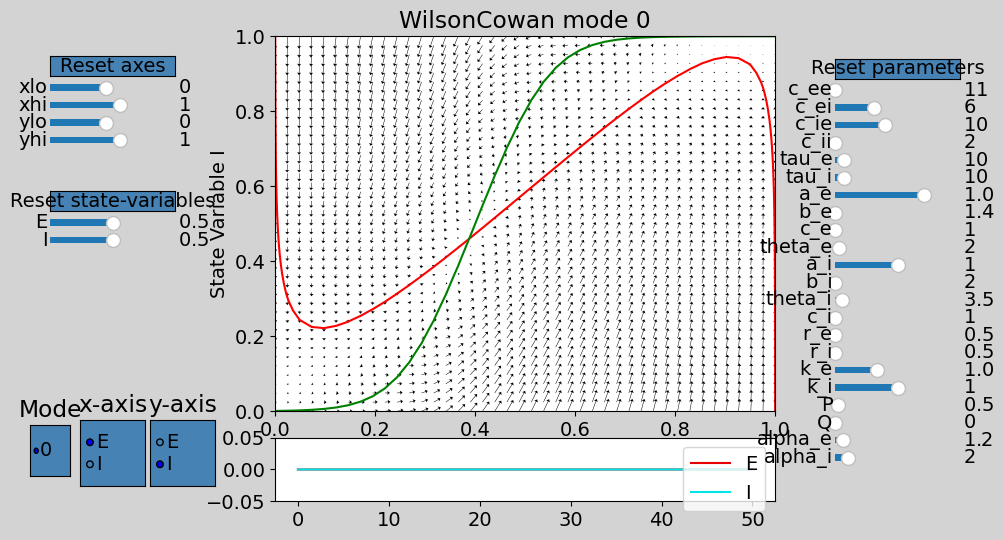

In [12]:
# Daffertshofer, A. and van Wijk, B. 
# On the influence of amplitude on the connectivity between phases 
# Frontiers in Neuroinformatics, July, 2011
D_wc = tsl.models.WilsonCowan()
D_wc.k_e = np.array([1.0])
D_wc.k_i = np.array([1.0])
D_wc.r_e = np.array([0.0])
D_wc.r_i = np.array([0.0])
D_wc.c_ee = np.array([10.0])
D_wc.c_ei = np.array([6.0])
D_wc.c_ie = np.array([10.0])
D_wc.c_ii = np.array([1.0])
D_wc.a_e = np.array([1.0])
D_wc.b_e = np.array([0.0])
D_wc.b_i = np.array([0.0])
D_wc.theta_e = np.array([2.0])
D_wc.theta_i = np.array([3.5])
D_wc.alpha_e = np.array([1.2])
D_wc.alpha_i = np.array([2.0])
D_wc.P = np.array([0.5])
D_wc.shift_sigmoid = np.array(False)

D_wc.state_variable_range['E'] = np.array([0.,1.0])
D_wc.state_variable_range['I'] = np.array([0.,1.0])

ppi = PhasePlaneInteractive(
    model=D_wc,
    integrator=tsl.integrators.HeunDeterministic(),
)
ppi.show()

   INFO  step 1 time 0.0001 s
   INFO  step 16001 time 1.0001 s
   INFO  step 32001 time 2.0001 s
   INFO  step 48001 time 3.0001 s
   INFO  step 64001 time 4.0001 s
   INFO  step 80001 time 5.0001 s
   INFO  step 96001 time 6.0001 s
   INFO  step 112001 time 7.0001 s
   INFO  step 128001 time 8.0001 s
   INFO  step 144001 time 9.0001 s


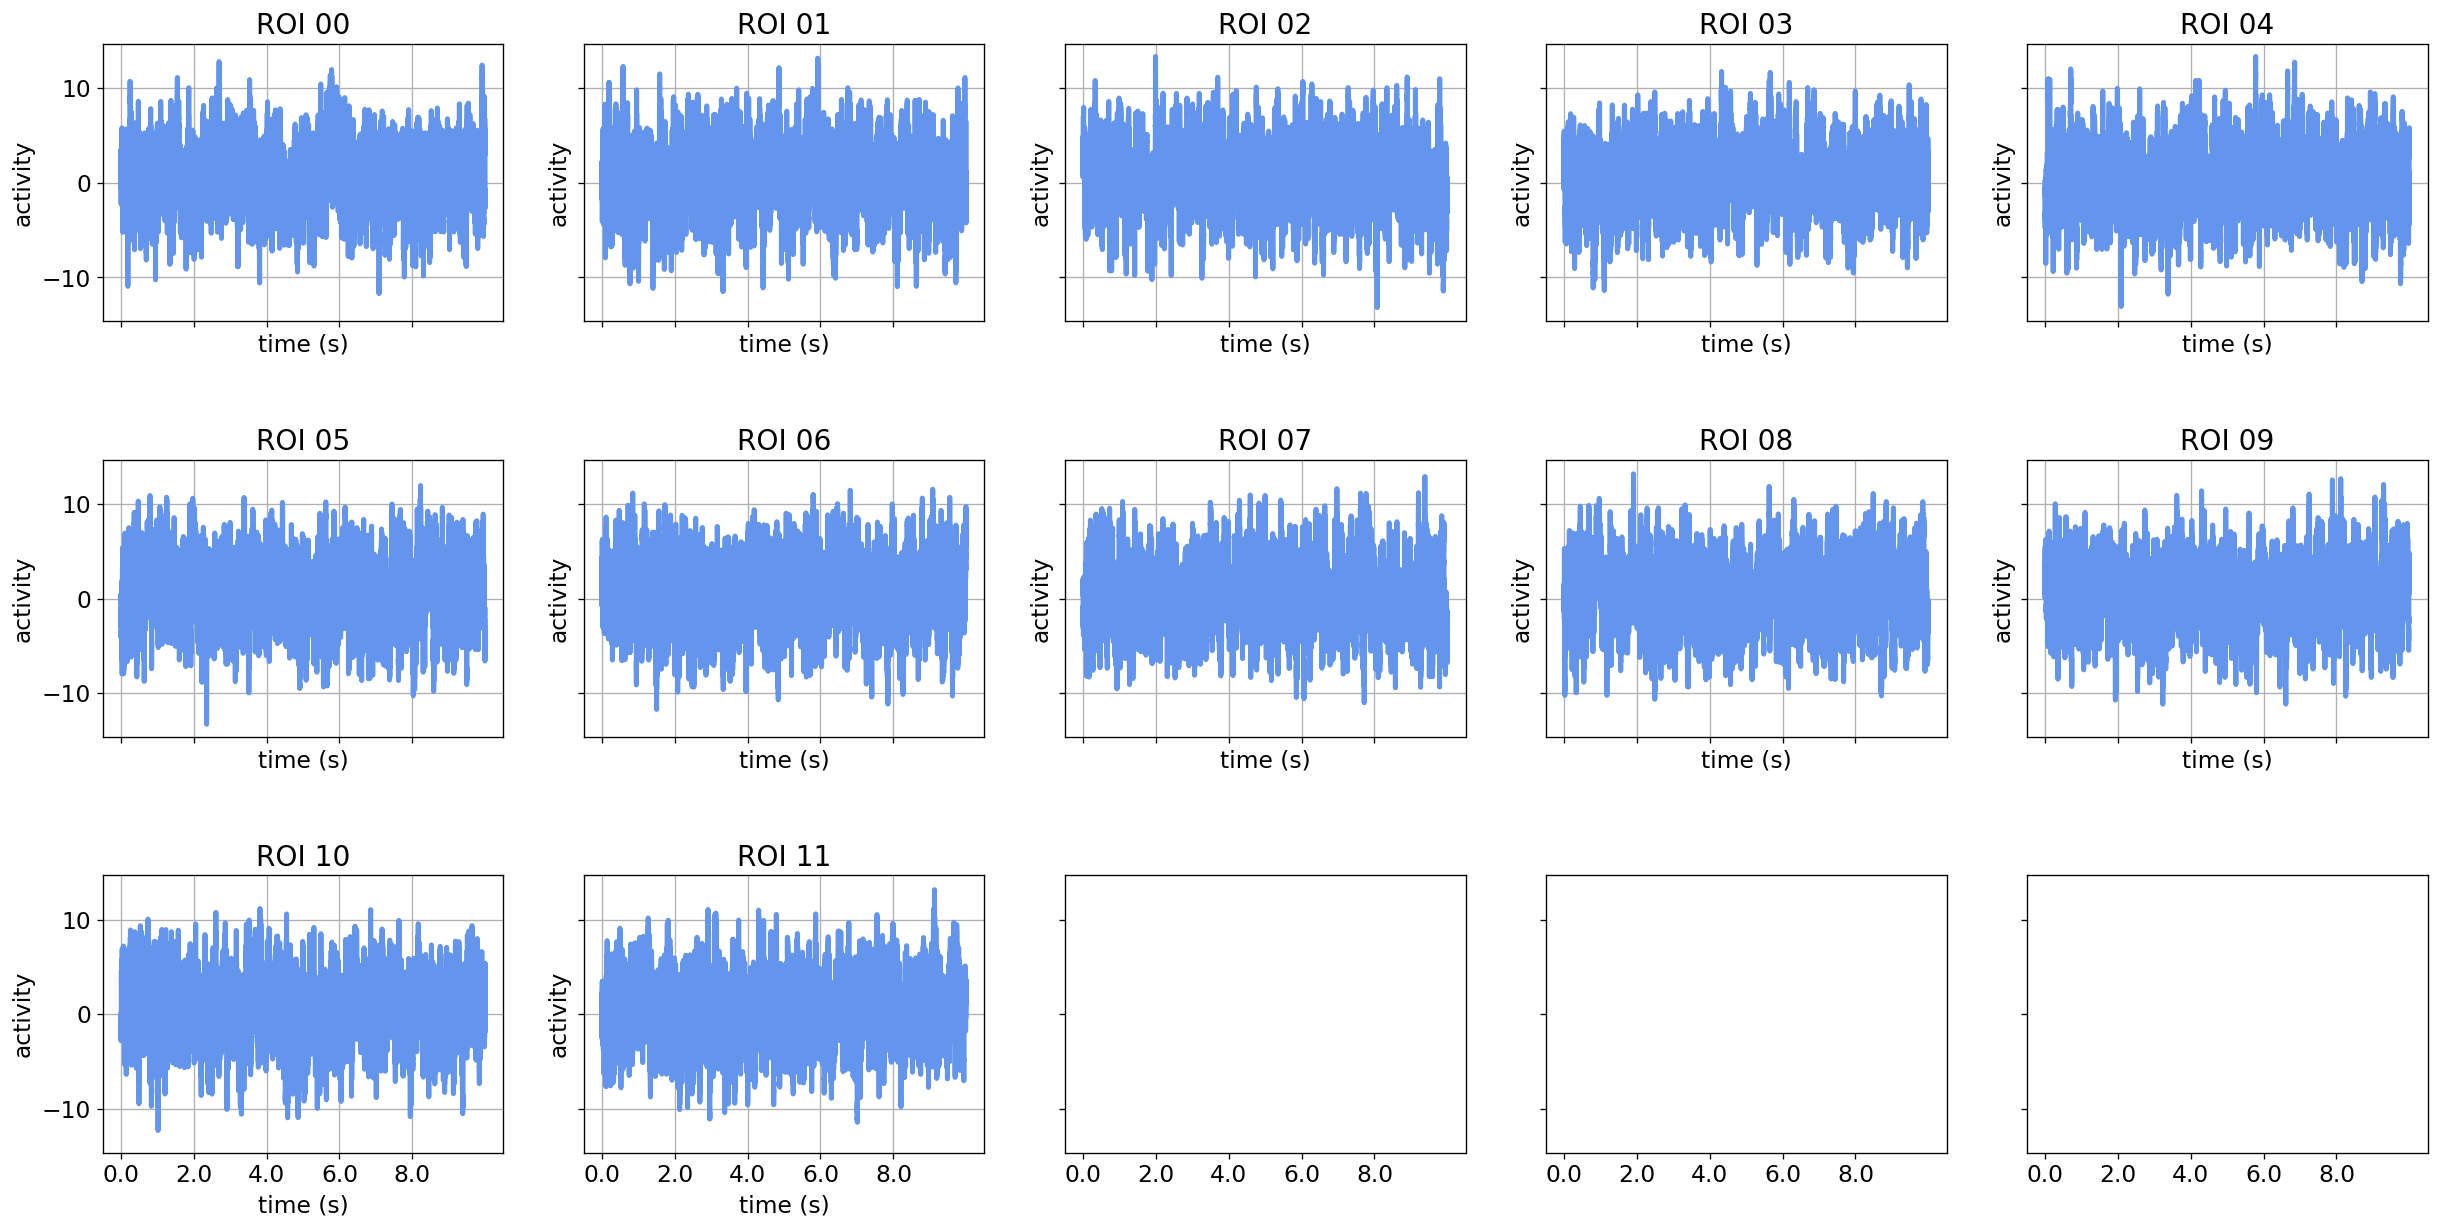

In [13]:
model = D_wc

coupling = tsl.coupling.Linear()

integrator = tsl.integrators.HeunStochastic(dt=2**-4, noise=tsl.noise.Additive())
# integrator = tsl.integrators.HeunDeterministic(dt=2**-3)

args.period = 2**-2
monitors = (
    # tsl.monitors.RawVoi(),
    # tsl.monitors.Bold(),
    tsl.monitors.TemporalAverage(period=args.period),
    tsl.monitors.ProgressLogger(period=1e3),
)

sim = tsl.simulator.Simulator(
    model=model, 
    connectivity=wm, 
    coupling=coupling, 
    integrator=integrator,
    monitors=monitors,
    simulation_length=1e4,
).configure()

run_res = sim.run()
time, data = run_res[0]
time.shape, data.shape

args.subplot_layout = 'row-col'
plot_roi_time_series(args, time, data)

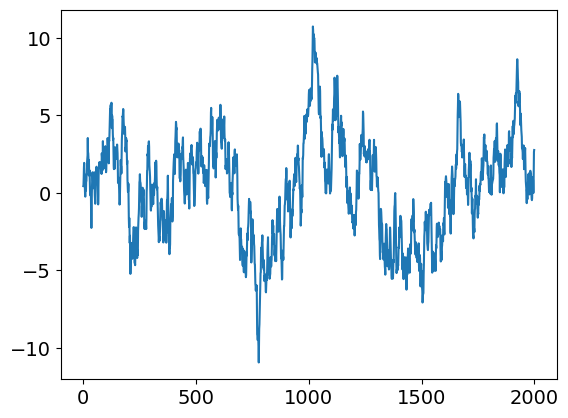

In [14]:
plt.plot(data[:2000, 0, 0, 0])

WARNING  random_state supplied for non-stochastic integration
   INFO  step 1 time 0.0001 s
   INFO  step 8001 time 1.0001 s
   INFO  step 16001 time 2.0001 s
   INFO  step 24001 time 3.0001 s
   INFO  step 32001 time 4.0001 s
   INFO  step 40001 time 5.0001 s
   INFO  step 48001 time 6.0001 s
   INFO  step 56001 time 7.0001 s
   INFO  step 64001 time 8.0001 s
   INFO  step 72001 time 9.0001 s


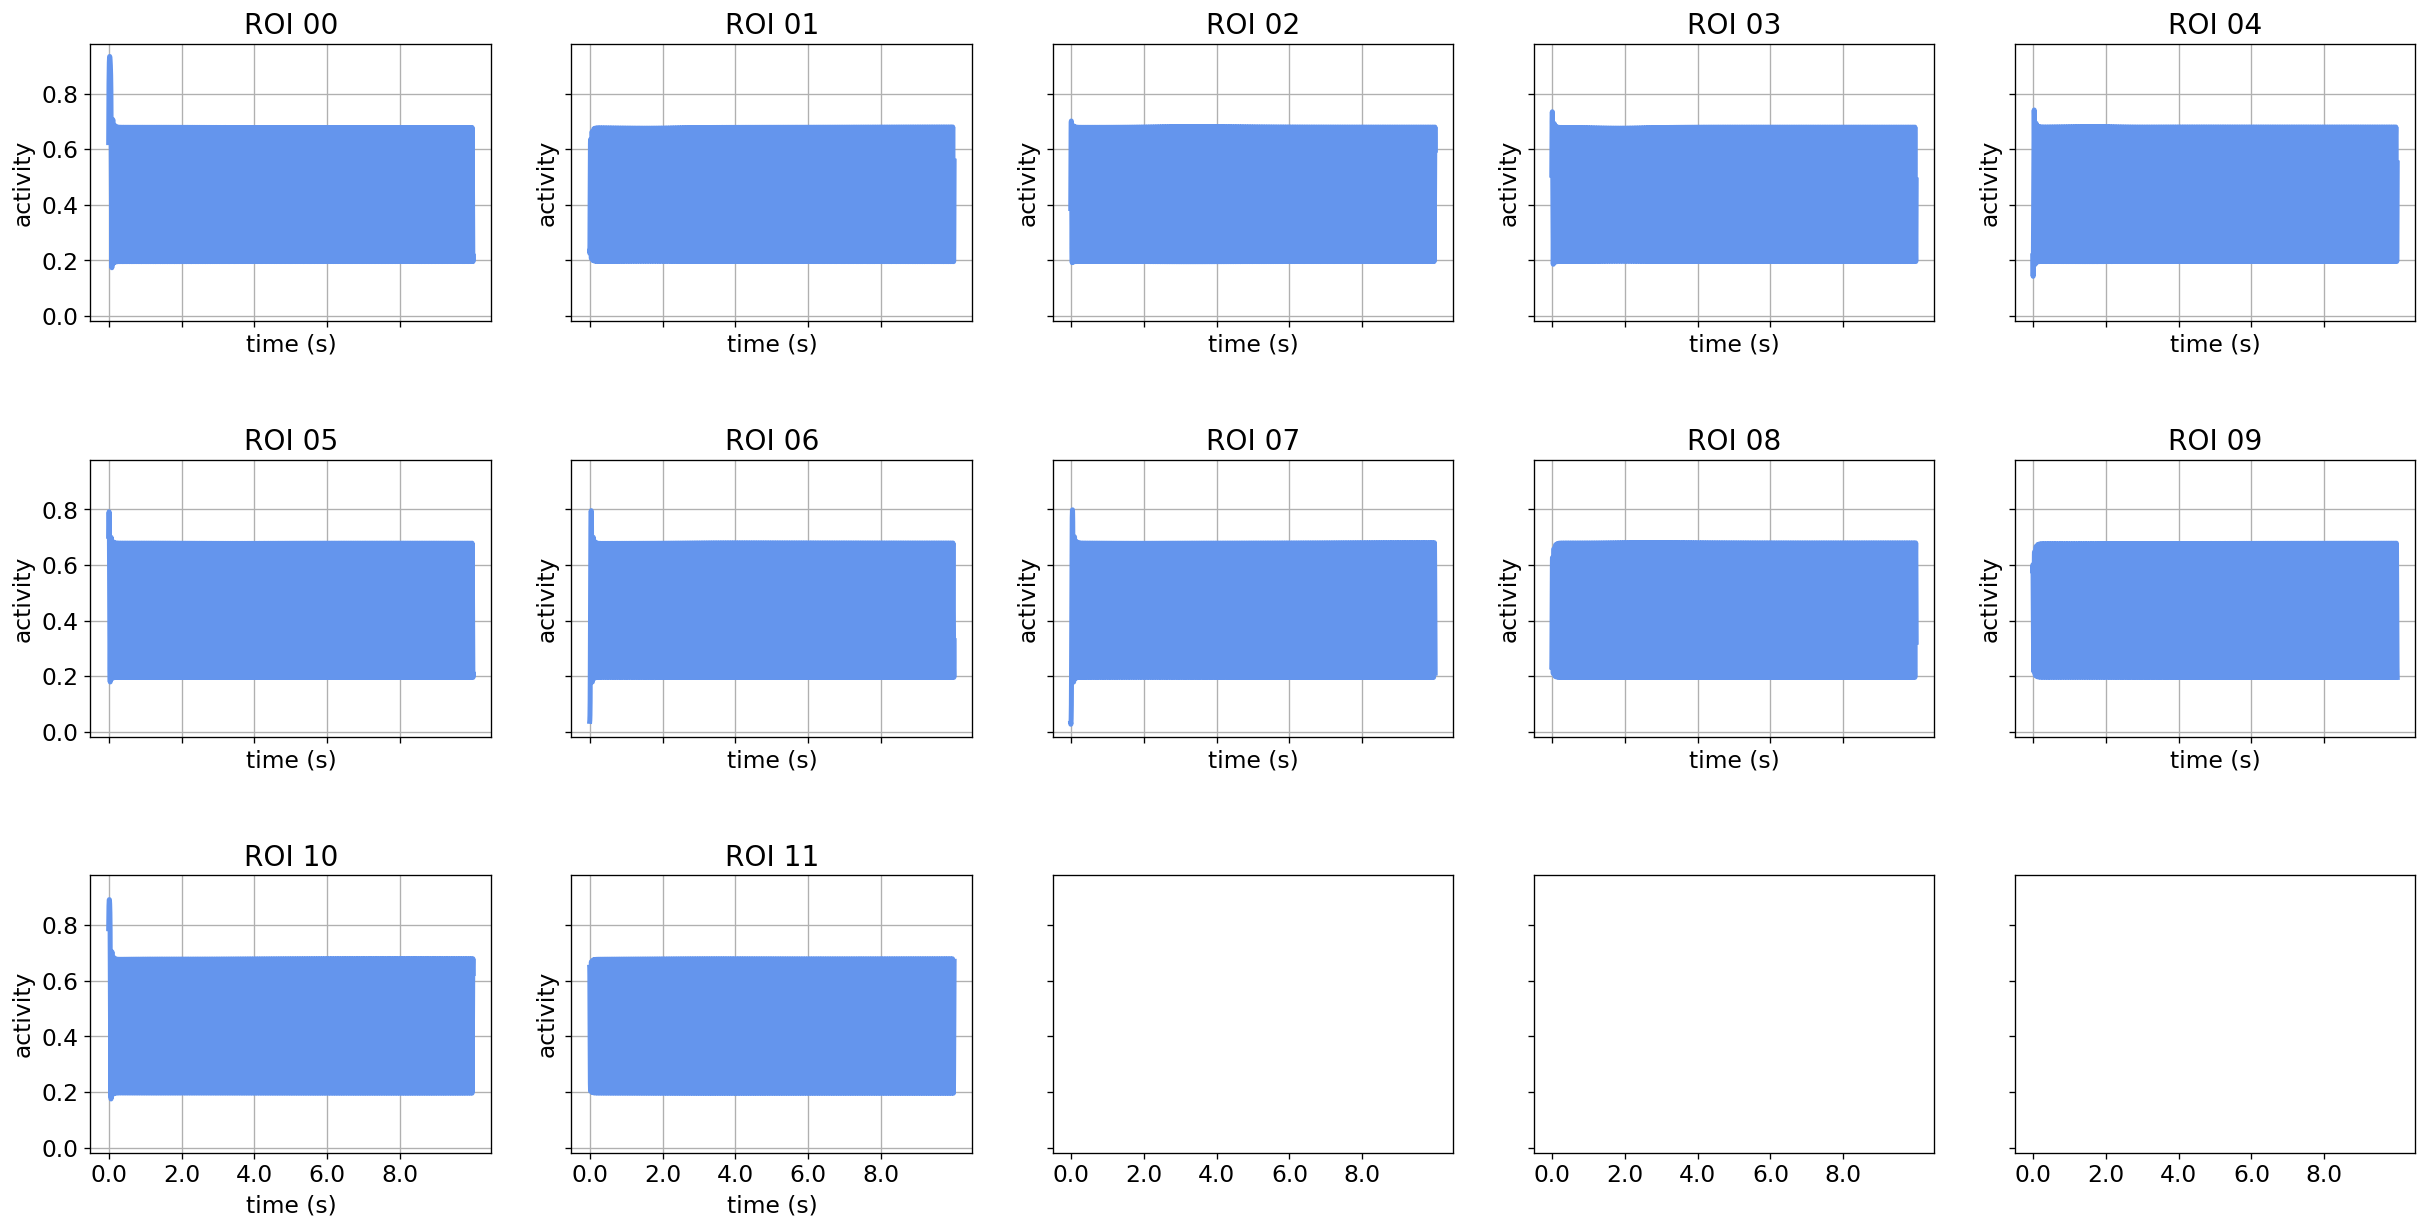

In [15]:
model = D_wc

coupling = tsl.coupling.Linear()

# integrator = tsl.integrators.HeunStochastic(dt=2**-4, noise=tsl.noise.Additive())
integrator = tsl.integrators.HeunDeterministic(dt=2**-3)

args.period = 2**-2
monitors = (
    # tsl.monitors.RawVoi(),
    # tsl.monitors.Bold(),
    tsl.monitors.TemporalAverage(period=args.period),
    tsl.monitors.ProgressLogger(period=1e3),
)

sim = tsl.simulator.Simulator(
    model=model, 
    connectivity=wm, 
    coupling=coupling, 
    integrator=integrator,
    monitors=monitors,
    simulation_length=1e4,
).configure()

run_res = sim.run()
time, data = run_res[0]
time.shape, data.shape

args.subplot_layout = 'row-col'
plot_roi_time_series(args, time, data)

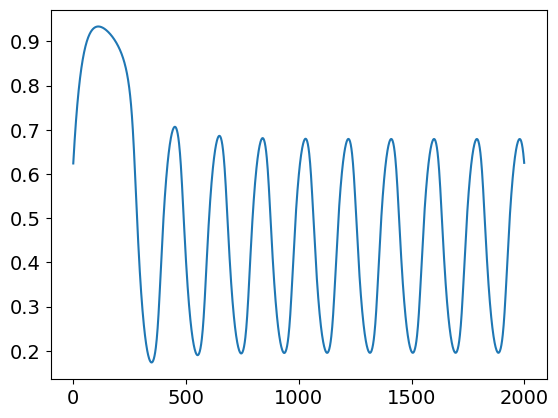

In [16]:
plt.plot(data[:2000, 0, 0, 0])